In [1]:
import scanpy as sc
import mnmstpy as mnmst
import pandas as pd
import numpy as np
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
import warnings
warnings.filterwarnings("ignore")

### Load data, please replace the data path to your own

In [2]:
section_id = "V1"
input_dir = os.path.join('D:/st_projects/data/Breast_Cancer', section_id)
adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')

sc.pp.filter_genes(adata, min_counts=10)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
hvg_filter = adata.var['highly_variable']

sc.pp.normalize_total(adata, inplace=True)
adata = adata[:, hvg_filter]
display(adata)

View of AnnData object with n_obs × n_vars = 3798 × 3001
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'

In [3]:
enhanced_adata, cell_spatial = mnmst.data_enhance(adata, k_nei=6)


Median distance to closest cell = 273.7480593538519
num_nbrs: 3001


In [4]:
sc.pp.pca(enhanced_adata, n_comps=50)
low_dim_x = enhanced_adata.obsm['X_pca']
expression = low_dim_x

### Load the ground truth label of BRCA dataset

In [5]:
gt = np.load(os.path.join(input_dir, 'cell_types.npy'))
adata.obs['ground_truth'] = gt
adata.obs['ground_truth'] = adata.obs['ground_truth'].astype('category')

In [6]:
import torch
from stacn import st_acn_gpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Z_all =  st_acn_gpu(expression, cell_spatial, lamb=0.0001, dim=200, device=device)
Z_all = Z_all.cpu().detach().numpy()

[st_acn] Iter 49: err=['2.0931e-05', '1.2245e-05'], max_err=4.7257e-04, thresh=1.0000e-05: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


In [8]:
import igraph as ig
import leidenalg
from natsort import natsorted
sources, targets = Z_all.nonzero()
ans_weight = Z_all[sources, targets]
g = ig.Graph(directed=True)
g.add_vertices(Z_all.shape[0])  # this adds adjacency.shape[0] vertices
g.add_edges(list(zip(sources, targets)))
g.es['weight'] = ans_weight

In [9]:
partition_type = leidenalg.RBConfigurationVertexPartition
# clustering proper
partition_kwargs = {'weights': np.array(g.es['weight']).astype(np.float64), 'n_iterations': -1, 'seed': 42, 'resolution_parameter': 1.35}

part = leidenalg.find_partition(g, partition_type, **partition_kwargs)
# store output into adata.obs
groups = np.array(part.membership)
leiden_label = pd.Categorical(
    values=groups.astype('U'),
    categories=natsorted(map(str, np.unique(groups))),
)
print(leiden_label)

['10', '0', '3', '7', '0', ..., '9', '0', '0', '7', '4']
Length: 3798
Categories (13, object): ['0', '1', '2', '3', ..., '9', '10', '11', '12']


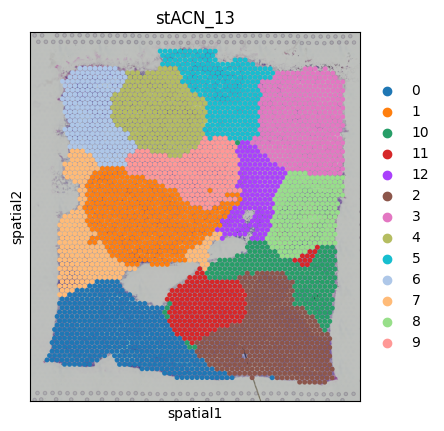

In [10]:
adata.obs['stACN_13'] = leiden_label
adata.obs['stACN_13'] = adata.obs['stACN_13'].astype('str')
adata.obs['stACN_13'] = adata.obs['stACN_13'].astype('category')
sc.pl.spatial(adata, color=['stACN_13'], size=1.5)

In [11]:
adjusted_rand_score(pd.Categorical(adata.obs['ground_truth']).codes, leiden_label)

0.6761614608717237